In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import warnings
import optuna
from lightgbm import LGBMRegressor
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
path = '.'

아래의 흐름과 같이 진행된 코드입니다.

1. 모델 및 데이터셋 선정

=> 회귀모델별 (LGBM, XGBoost, RandomForest) & train_ohe, train_label 비교 ( 인코딩방식 차이 )

=> metrics : r2_score

=> 모델 및 인코딩 방식에 따른 데이터셋 선정

2. 모델의 타당성 예측

=> y_test가 없으므로 train_test_split을 통한 x_train,y_train,x_valid,y_valid 생성

=> y_val_pred = model.predict(x_valid)

=> y_val_pred와 y_valid 비교를 통한 모델의 성능 확인 및 시각화

3. 테스트 셋에 적용 

=> 4개의 테스트셋 ( 1주 전 프로모션 10개/ 2주 전 프로모션 10개 / 1주 전 프로모션 15개 / 2주 전 프로모션 15개)
=> y_test 생성 후 그래프 

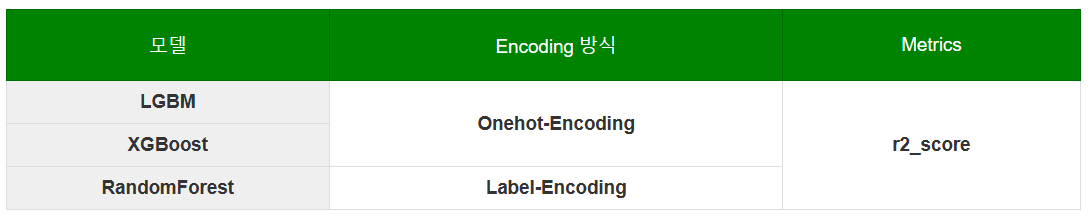

# Train셋 선정 및 모델 선정

## train_onehot & train_label 점수 비교

In [2]:
# train ( onehot encoding )
train_onehot = pd.read_csv(f'{path}/train_onehot.csv')
train_onehot['날짜'] = pd.to_datetime(train_onehot['날짜'])
train_onehot = train_onehot.set_index('날짜')
train_onehot = train_onehot.drop(columns=['Bridge','Event','Work Day'])

# train ( label encoding )
train_label = pd.read_csv(f'{path}/train_label.csv')
train_label['날짜'] = pd.to_datetime(train_label['날짜'])
train_label = train_label.set_index('날짜')

###  train_ohe

In [3]:
# train_ohe 데이터셋의 성능확인
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

In [4]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "regression",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    
    X_train = X_train.sort_index()
    X_valid = X_valid.sort_index()
    y_train = y_train.sort_index()
    y_valid = y_valid.sort_index()
    
    model = LGBMRegressor(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, lgb_pred)
    return r2

In [5]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-05-17 20:33:55,555] A new study created in memory with name: lgbm_parameter_opt
[I 2023-05-17 20:33:55,664] Trial 0 finished with value: 0.2975407983838204 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.2975407983838204.
[I 2023-05-17 20:33:56,912] Trial 1 finished with value: 0.6723180766952992 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.6723180766952992.
[I 2023-05-17 20:33:57,113] Trial 2 finished with value: 0.35394572141018055 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lamb

Best Score: 0.8739041774391114
Best trial: {'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459}


### train_label

In [6]:
# train_label 데이터셋의 성능확인
X_label = train_label.drop(columns='판매량')
y_label = train_label['판매량']

In [7]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "regression",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_label, y_label, test_size=0.2)
    
    X_train = X_train.sort_index()
    X_valid = X_valid.sort_index()
    y_train = y_train.sort_index()
    y_valid = y_valid.sort_index()
    
    model = LGBMRegressor(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, lgb_pred)
    return r2

In [8]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-05-17 20:34:04,837] A new study created in memory with name: lgbm_parameter_opt
[I 2023-05-17 20:34:04,935] Trial 0 finished with value: 0.25540401581049965 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.25540401581049965.
[I 2023-05-17 20:34:06,452] Trial 1 finished with value: 0.7306098898900995 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.7306098898900995.
[I 2023-05-17 20:34:06,530] Trial 2 finished with value: 0.35264363322499914 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_la

Best Score: 0.864813282224326
Best trial: {'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459}


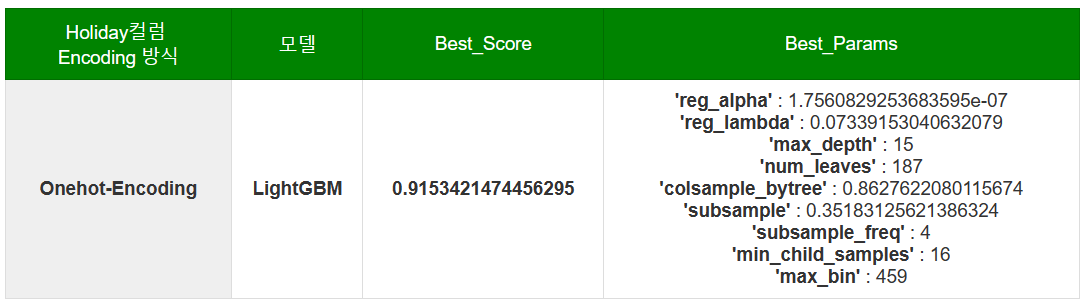

## 모델의 예측 타당성 ( 정확성 )

* 현실에서 y_test의 데이터는 없음

  => y_valid & y_val_pred 그래프로 모델의 정확성(성능) 확인

In [9]:
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

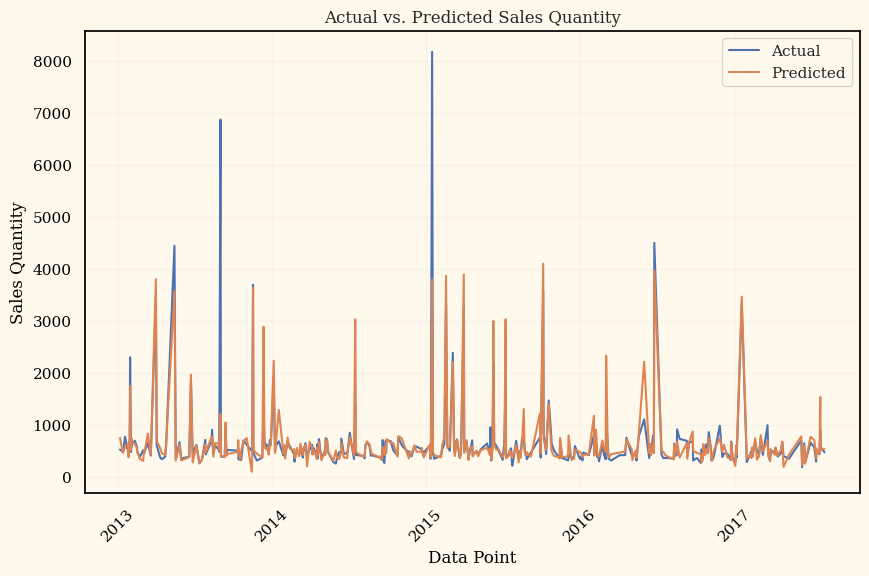

In [11]:
# Valid 셋 생성
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# 모델 생성 및 하이퍼 파라미터 지정
model = LGBMRegressor(reg_alpha = 1.7560829253683595e-07, reg_lambda = 0.07339153040632079, 
                      max_depth = 15, num_leaves = 187, colsample_bytree = 0.8627622080115674, 
                      subsample = 0.35183125621386324, 
                      subsample_freq = 4, min_child_samples = 16, max_bin = 459)

# 모델 학습 
model.fit(X_train, y_train)
y_val_pred = model.predict(X_valid)

# valid 예측 시각화
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

plt.figure(figsize=(10, 6))
plt.plot(y_valid.index.sort_values(), y_valid, label='Actual')
plt.plot(y_valid.index.sort_values(), y_val_pred, label='Predicted')
plt.xlabel('Data Point')
plt.ylabel('Sales Quantity')
plt.title('Actual vs. Predicted Sales Quantity')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Test 셋 선정 및 머신러닝 진행

## 1주전 프로모션 10개 

In [13]:
# test ( 1주전부터 프로모션 10개 진행)
test_1_10 = pd.read_csv(f'{path}/test_1_10_onehot.csv')
test_1_10.rename(columns={'date':'날짜',
                         })
test_1_10['날짜'] = pd.to_datetime(test_1_10['날짜'])
test_1_10 = test_1_10.set_index('날짜')

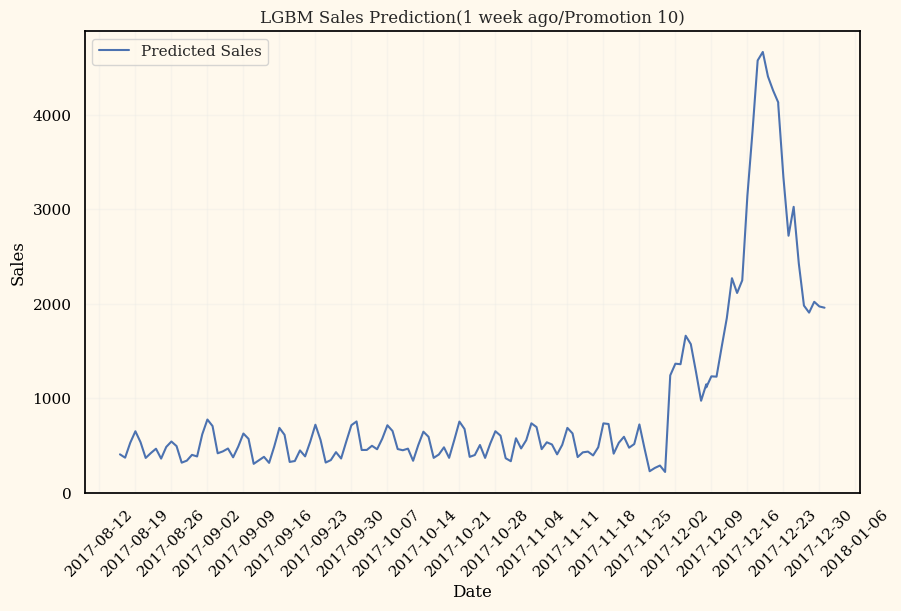

In [14]:
# 모델 선정 및 학습
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

model = LGBMRegressor(reg_alpha = 1.7560829253683595e-07, reg_lambda = 0.07339153040632079, 
                      max_depth = 15, num_leaves = 187, colsample_bytree = 0.8627622080115674, 
                      subsample = 0.35183125621386324, 
                      subsample_freq = 4, min_child_samples = 16, max_bin = 459)
model.fit(X, y)
y_pred_1_10 = model.predict(test_1_10)

# 예측 결과 그래프 그리기
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

plt.figure(figsize=(10, 6))
plt.plot(test_1_10.index, y_pred_1_10, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LGBM Sales Prediction(1 week ago/Promotion 10)')
plt.legend()

# xticks 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 7일 간격으로 xticks 표시

plt.xticks(rotation=45)
plt.show()

## 1주 전 프로모션 15개

In [15]:
# test ( 1주전부터 프로모션 15개 진행)
test_1_15 = pd.read_csv(f'{path}/test_1_15_onehot.csv')
test_1_15.rename(columns={'date':'날짜',
                         })
test_1_15['날짜'] = pd.to_datetime(test_1_15['날짜'])
test_1_15 = test_1_15.set_index('날짜')

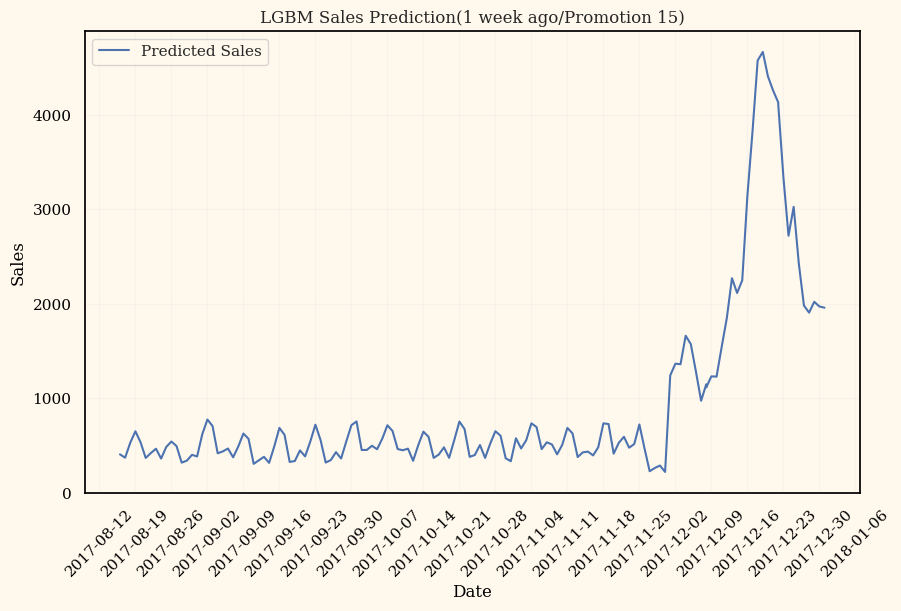

In [16]:
# 모델 선정 및 학습
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

model = LGBMRegressor(reg_alpha = 1.7560829253683595e-07, reg_lambda = 0.07339153040632079, 
                      max_depth = 15, num_leaves = 187, colsample_bytree = 0.8627622080115674, 
                      subsample = 0.35183125621386324, 
                      subsample_freq = 4, min_child_samples = 16, max_bin = 459)
model.fit(X, y)
y_pred_1_15 = model.predict(test_1_15)

# 예측 결과 그래프 그리기
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

plt.figure(figsize=(10, 6))
plt.plot(test_1_15.index, y_pred_1_15, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LGBM Sales Prediction(1 week ago/Promotion 15)')
plt.legend()

# xticks 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 7일 간격으로 xticks 표시

plt.xticks(rotation=45)
plt.show()

## 2주 전 프로모션 10개

In [17]:
# test ( 2주전부터 프로모션 10개 진행)
test_2_10 = pd.read_csv(f'{path}/test_2_10_onehot.csv')
test_2_10.rename(columns={'date':'날짜',
                         })
test_2_10['날짜'] = pd.to_datetime(test_2_10['날짜'])
test_2_10 = test_2_10.set_index('날짜')

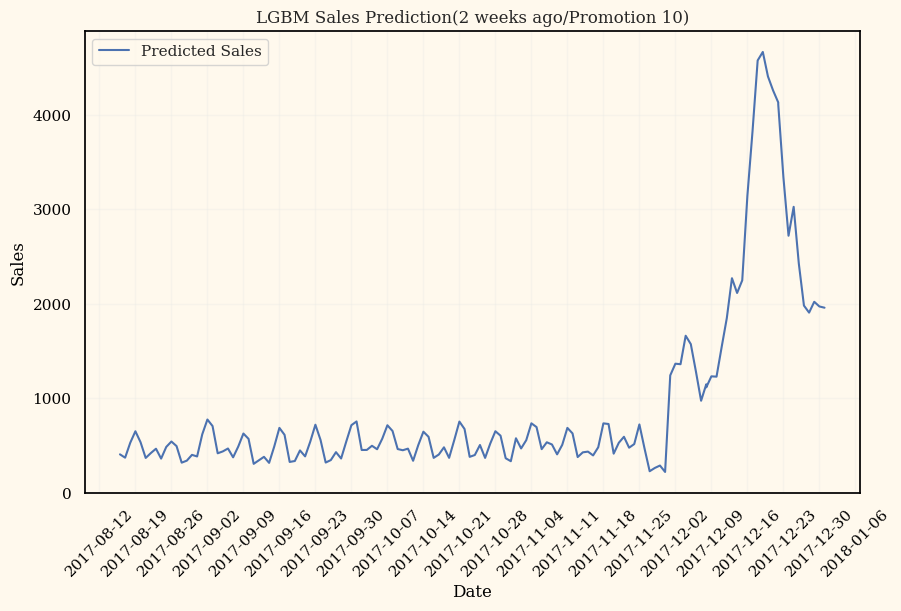

In [18]:
# 모델 선정 및 학습
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

model = LGBMRegressor(reg_alpha = 1.7560829253683595e-07, reg_lambda = 0.07339153040632079, 
                      max_depth = 15, num_leaves = 187, colsample_bytree = 0.8627622080115674, 
                      subsample = 0.35183125621386324, 
                      subsample_freq = 4, min_child_samples = 16, max_bin = 459)
model.fit(X, y)
y_pred_2_10 = model.predict(test_2_10)

# 예측 결과 그래프 그리기
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

plt.figure(figsize=(10, 6))
plt.plot(test_1_15.index, y_pred_1_15, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LGBM Sales Prediction(2 weeks ago/Promotion 10)')
plt.legend()

# xticks 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 7일 간격으로 xticks 표시

plt.xticks(rotation=45)
plt.show()

## 2주 전 프로모션 15개

In [20]:
# test ( 2주전부터 프로모션 15개 진행)
test_2_15 = pd.read_csv(f'{path}/test_2_15_onehot.csv')
test_2_15.rename(columns={'date':'날짜',
                         })
test_2_15['날짜'] = pd.to_datetime(test_2_15['날짜'])
test_2_15 = test_2_15.set_index('날짜')

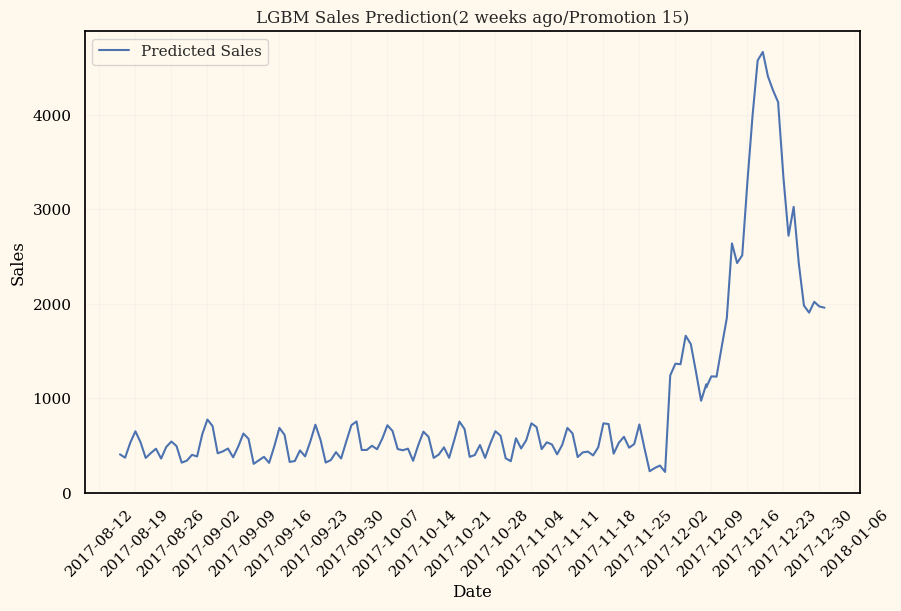

In [21]:
# 모델 선정 및 학습
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

model = LGBMRegressor(reg_alpha = 1.7560829253683595e-07, reg_lambda = 0.07339153040632079, 
                      max_depth = 15, num_leaves = 187, colsample_bytree = 0.8627622080115674, 
                      subsample = 0.35183125621386324, 
                      subsample_freq = 4, min_child_samples = 16, max_bin = 459)
model.fit(X, y)
y_pred_2_15 = model.predict(test_2_15)

# 예측 결과 그래프 그리기
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

plt.figure(figsize=(10, 6))
plt.plot(test_2_15.index, y_pred_2_15, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('LGBM Sales Prediction(2 weeks ago/Promotion 15)')
plt.legend()

# xticks 간격 설정
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 7일 간격으로 xticks 표시

plt.xticks(rotation=45)
plt.show()

# 최종 테스트셋 선정 및 결과값 도출

In [23]:
# 4개의 그래프 비교 
# 1주전 프로모션 진행 데이터 보다 2주 전 프로모션 진행 데이터가 12월 중순의 판매량 소폭 증가
# => 프로모션 2주 전 (12/13~)
# 프로모션 개수 (10 / 15) 차이는 전혀 없다고 봐도 무방
# 비용 및 프로모션 효율 고려하여 10개로 진행
# => 프로모션 개수 10개 로 진행

In [35]:
# test ( 2주전부터 프로모션 10개 진행)
test_2_10 = pd.read_csv(f'{path}/test_2_10_onehot.csv')
test_2_10.rename(columns={'date':'날짜',
                         })
test_2_10['날짜'] = pd.to_datetime(test_2_10['날짜'])
test_2_10 = test_2_10.set_index('날짜')

# 모델 선정 및 핛ㅂ
X = train_onehot.drop(columns='판매량')
y = train_onehot['판매량']

model = LGBMRegressor(reg_alpha = 1.7560829253683595e-07, reg_lambda = 0.07339153040632079, 
                      max_depth = 15, num_leaves = 187, colsample_bytree = 0.8627622080115674, 
                      subsample = 0.35183125621386324, 
                      subsample_freq = 4, min_child_samples = 16, max_bin = 459)
model.fit(X, y)
y_pred_2_10 = model.predict(test_2_10)

In [36]:
# y_pred 값 list 변환
y_pred_2_10_list = list(y_pred_2_10)

# df 생성
index = test_2_10.index
values = y_pred_2_10_list
data = {'판매량': values}

# 2017년 Sales
_2017년_하반기_예상_판매량_sales = pd.DataFrame(data=data, index=index)
_2017년_하반기_예상_판매량_sales

,판매량
날짜,
2017-08-16,407.514885
2017-08-17,372.296657
2017-08-18,530.519947
2017-08-19,651.805894
2017-08-20,535.881709
...,...
2017-12-27,1981.268263
2017-12-28,1906.912978
2017-12-29,2021.525882
